# 【例題2.8】

## (6) 洪水追跡計算
### ③Dynamic wave法による洪水追跡計算プログラム

- Dynamic wave法による洪水追跡計算を行うプログラム

- 計算条件は，エクセルファイル”DWInput.xlsx”をご確認ください．
    - 計算条件の設定は，"計算条件"のシートで行います．
    - 上流端流量の設定は，"上流端流量の経時変化"のシートで行います．
    - 上流端流量ハイドログラフは，プログラム"Discharge/discharge.py"で作成します．


- 各時刻の水深，流積，流速，流量の空間分布が，"DW/ResDWave.xlsx"に出力されます．

- "DW/2_8_6graph.py"で，計算結果をグラフにできます．

In [4]:
"""dynamic wave 法による洪水追跡計算."""
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import decimal
# 定数の設定
GRAVITY_ACCELERATION: float = 9.81  # 重力加速度
INPUT_FILE_NAME = "DWInput.xlsx"
SHEET1_NAME = "計算条件"
SHEET2_NAME = "上流端流量の経時変化"
OUTPUT_FILE_NAME = "DW/ResDWave.xlsx"
EPS_DEPTH = 1e-10
_GRAPH_DT = 0.001
decimal.getcontext().prec = 10

### 流れの諸量を計算するクラス

In [5]:
class FlowParam:
    """流れの諸量計算するクラス."""

    @staticmethod
    def calcA(_h, _B):
        """流積."""
        return (_h * _B)

    @staticmethod
    def calc_s(_h, _B):
        """潤辺."""
        return (_B + 2. * _h)

    @staticmethod
    def calcR(_A, _s):
        """径深."""
        return (_A / _s)

    @staticmethod
    def calcIf(_A, _Q, _B, _n):
        """摩擦勾配."""
        __s = FlowParam.calc_s(_A/_B, _B)
        __R = FlowParam.calcR(_A, __s)
        __If = _n**2.*(_Q*np.abs(_Q)/_A**2.)/(__R**(4./3.))
        return (__If)

    @staticmethod
    def calcQ0(_n, _A, _R, _Ib):
        """等流時の流量を求める関数."""
        return (1. / _n * _A * _R**(2. / 3.) * _Ib**.5)

    @staticmethod
    def __eqUniform(_h, _n, _B, _Ib, _Q):
        """等流の関係."""
        __A = FlowParam.calcA(_h, _B)
        __s = FlowParam.calc_s(_h, _B)
        __R = FlowParam.calcR(__A, __s)
        return (np.abs(-_Ib + _n**2. * (_Q / __A)**2. / __R**(4. / 3.)))

    @staticmethod
    def calch0(_n, _B, _Ib, _Q):
        """等流水深を求める関数."""
        __sh = (_n * _n * (_Q / _B)**2. / _Ib)**(3. / 10.)
        __h0 = scipy.optimize.fmin(FlowParam.__eqUniform, x0=[__sh],
                                   xtol=EPS_DEPTH,  disp=False,
                                   args=(_n, _B, _Ib, _Q, ))[0]
        return (__h0)

    @staticmethod
    def calcC(_A, _B):
        """波速の計算."""
        return (np.sqrt(GRAVITY_ACCELERATION*_A/_B))

### グラフ作成のためのクラス

In [6]:
class PltGraph():
    """解析結果を可視化するクラス."""

    def __init__(self, x, zb, h, u):
        """初期条件をプロット."""
        self.fig = plt.figure()
        self.ax1 = plt.subplot(1, 1, 1)
        self.lines, = self.ax1.plot(x, h + zb)
        self.lines2, = self.ax1.plot(x, zb)
        self.ax1.set_xlim(x.min(), x.max())
        self.ax1.set_ylabel("$H$, $z_b$(m)")
        self.ax1.grid()
        self.ax1.set_xlabel("$x$(km)")
        plt.pause(_GRAPH_DT)

    def replot(self, x, zb, h, u):
        """再プロットするための関数."""
        H = h+zb
        self.ax1.set_ylim((H.min(), H.max()))
        self.lines.set_data(x, h+zb)
        plt.pause(_GRAPH_DT)

### Dynamic Wave法のクラス

$\frac{\partial \boldsymbol{U}}{\partial t}+\frac{\partial \boldsymbol{E}}{\partial x}=\boldsymbol{S}$

$\boldsymbol{U} = \left(\begin{matrix}A \\ Q\end{matrix}\right)$；
$\boldsymbol{E} = \left(\begin{matrix}Q \\ \frac{Q^2}{A}+\frac{g}{2}\frac{A^2}{B}\end{matrix}\right)$；
$\boldsymbol{S}=\left(\begin{matrix}0 \\ gA(I_b-I_f)\end{matrix}\right)$


$\boldsymbol{U}_i^{t+\Delta t} = \boldsymbol{U}_i^{t}-\frac{\Delta t}{\Delta x}\left(\boldsymbol{E}^{\ast}_{i+1/2}-\boldsymbol{E}^{\ast}_{i-1/2}\right)+\boldsymbol{S}_i \Delta t$

$\boldsymbol{E}^{\ast}_{i+1/2} = \frac{1}{2}\left[\boldsymbol{E}^t_{i+1}+\boldsymbol{E}^t_{i}-\left\{\tilde{\alpha}^1\Psi(\tilde{\lambda^1})\tilde{\boldsymbol{e}}^1+\tilde{\alpha}^2\Psi(\tilde{\lambda^2})\tilde{\boldsymbol{e}}^2\right\}\right]$


$\left(\begin{matrix}\tilde{\lambda}^1 \\ \tilde{\lambda}^2 \end{matrix}\right) = \left(\begin{matrix}\tilde{u}+\tilde{c} \\ \tilde{u}-\tilde{c} \end{matrix}\right)$，
$\left(\begin{matrix}\tilde{\alpha}^1 \\ \tilde{\alpha}^2 \end{matrix}\right) = -\frac{1}{2\tilde{c}}\left(\begin{matrix}\tilde{\lambda}^2(A^t_{i+1}-A^t_{i})-(Q^t_{i+1}-Q^t_{i}) \\ -\tilde{\lambda}^1(A^t_{i+1}-A^t_{i})+(Q^t_{i+1}-Q^t_{i}) \end{matrix}\right)$，
$\boldsymbol{e}^1=\left(\begin{matrix}1 \\ \tilde{\lambda}^1 \end{matrix}\right)$，
$\boldsymbol{e}^2 = \left(\begin{matrix}1 \\ \tilde{\lambda}^2 \end{matrix}\right)$である．

$\tilde{u}=\frac{\tilde{Q}}{\tilde{A}}$，$\tilde{c}=\sqrt{g\tilde{A}/B}$，$\tilde{A} = \frac{A^t_{i+1}+A^t_{i}}{2}$，$\tilde{Q}=\frac{Q^t_{i+1}\sqrt{A^t_{i+1}}+Q^t_{i}\sqrt{A^t_{i}}}{\sqrt{A^t_{i+1}}+\sqrt{A^t_{i}}}$である．また，$\Psi(\tilde{\lambda^j})$は次式で表されるエントロピー補正である．

$\Psi(\tilde{\lambda^j}) = \left\{\begin{matrix} \lvert \tilde{{\lambda^j}}\rvert & \text{if} \, \lvert \tilde{{\lambda^j}}\rvert \ge \frac{1}{2}\delta^j　 \\ (\tilde{{\lambda^j}})^2/\delta^j+\frac{1}{4}\delta^j & \text{if} \, \lvert \tilde{{\lambda^j}}\rvert < \frac{1}{2}\delta^j　 \end{matrix} \right.$

ここに，$\delta^j = \max(0, 4\Delta \lambda^j)$，
$\Delta=(\bigcirc^t_{i+1}-\bigcirc^t_{i})$である．

In [7]:
class DynamicWave():
    """Dynamic Wave法のクラス."""

    def __init__(self):
        """初期化関数."""
        # データの読み込み
        self.__set_value()
        # 初期条件の作成
        self.__setInitCond()

    def __setInitCond(self):
        """初期条件と変数の設定."""
        # データ整理
        self.x = np.linspace(0.0, self.xEnd,
                             self.totalGridNo) / 1000.0  # x(km)
        # 等流水深
        __h0 = FlowParam.calch0(self.n, self.B, self.Ib, self.Qb[0])
        __A0 = FlowParam.calcA(__h0, self.B)
        # 水深h,河床位の配列を作成
        self.h = np.zeros(self.totalGridNo)
        self.h[:] = __h0
        self.zb = np.linspace(self.xEnd * self.Ib, 0.0, self.totalGridNo)
        # データフレームの作成
        self.df = pd.DataFrame(self.x, columns=['x(km)'])
        self.df['zb(m)'] = self.zb
        # 配列の生成
        self.U = np.zeros([self.totalGridNo, 2])  # U[;,0]:A，U[:,1]:Q
        self.U[:, 0] = __A0
        self.U[:, 1] = self.Qb[0]
        self.E = np.zeros([self.totalGridNo, 2])
        self.S2 = np.zeros([self.totalGridNo, 2])

    def __set_value(self):
        """ファイルの読み込み."""
        self.data = pd.read_excel(INPUT_FILE_NAME, sheet_name=None)
        # 計算条件の読み込み
        print(self.data[SHEET1_NAME])
        __colName = self.data[SHEET1_NAME].columns
        # 河床勾配Ib
        self.Ib = self.data[SHEET1_NAME][__colName[1]][0]
        # 川幅B(m)
        self.B = self.data[SHEET1_NAME][__colName[1]][1]
        # 粗度係数n
        self.n = self.data[SHEET1_NAME][__colName[1]][2]
        # 計算距離
        self.xEnd = self.data[SHEET1_NAME][__colName[1]][3] * 1000.
        # 分割数
        self.totalDivNo = int(self.data[SHEET1_NAME][__colName[1]][4])
        # 全格子数
        self.totalGridNo = self.totalDivNo + 1
        # 格子幅dx
        self.dx = self.xEnd / self.totalDivNo
        # 計算時間 hr ->sec
        self.timeEnd = self.data[SHEET1_NAME][__colName[1]][5] * 3600.
        # 出力時間
        # min -> sec
        self.outputTime = self.data[SHEET1_NAME][__colName[1]][6] * 60.0
        # クーラン数
        self.Cr = self.data[SHEET1_NAME][__colName[1]][7]
        # 上流端流量の読み込み
        print(self.data[SHEET2_NAME])
        __colName = self.data[SHEET2_NAME].columns
        self.tb = np.array(self.data[SHEET2_NAME][__colName[0]]) * 3600.  # 時刻
        self.Qb = np.array(self.data[SHEET2_NAME][__colName[1]])  # 流量

    def __calc_dT(self, _outputTime, _lambda):
        """時間の刻み幅dtの計算."""
        __dT = np.min([self.Cr*self.dx/np.max(_lambda),
                       self.outputTime-_outputTime])
        return (__dT)

    def __E_Flux(self, U):
        """fluxEの計算."""
        self.E[:, 0] = U[:, 1]
        self.E[:, 1] = (U[:, 1]**2. / U[:, 0] +
                        .5 * GRAVITY_ACCELERATION * U[:, 0]**2./self.B)

    def __S2_Flux(self, _A, _Q):
        """fluxSの計算."""
        self.S2[:, 0] = 0.0
        __If = FlowParam.calcIf(_A, _Q, self.B, self.n)
        self.S2[:, 1] = GRAVITY_ACCELERATION * _A * (self.Ib-__If)

    def __RoeAve(self):
        """ROEの平均."""
        __tilde_A = np.zeros_like(self.U[:, 0])
        __tilde_Q = np.zeros_like(self.U[:, 0])
        __sqrt_A = np.zeros_like(self.U[:, 0])
        __tilde_A[:-1] = (self.U[:-1, 0] + self.U[1:, 0]) * .5
        __sqrt_A = self.U[:, 0]**.5
        __Q = self.U[:, 1]
        __tilde_Q[:-1] = ((__Q[1:] * __sqrt_A[1:] + __Q[:-1] * __sqrt_A[:-1]) /
                          (__sqrt_A[1:] + __sqrt_A[:-1]))
        return (__tilde_A, __tilde_Q)

    def __Lambda(self, __tilde_u, __tilde_h):
        """特性速度."""
        __c = np.sqrt(GRAVITY_ACCELERATION * __tilde_h)
        return (__tilde_u + __c, __tilde_u - __c)

    def __vector_e(self, __tilde_Lambda):
        """固有ベクトル."""
        __tilde_e1 = np.zeros_like(self.U)
        __tilde_e2 = np.zeros_like(self.U)
        __tilde_e1[:, 0] = 1.0
        __tilde_e1[:, 1] = __tilde_Lambda[:, 0]
        __tilde_e2[:, 0] = 1.0
        __tilde_e2[:, 1] = __tilde_Lambda[:, 1]
        return (__tilde_e1, __tilde_e2)

    def __alpha(self, __tilde_Lambda):
        """Wave Strength."""
        _2c = __tilde_Lambda[:, 0] - __tilde_Lambda[:, 1]
        __tilde_alpha = np.zeros_like(self.U)
        __tilde_alpha[:-1, 0] = -1. / _2c[:-1] * (__tilde_Lambda[:-1, 1] *
                                                  (self.U[1:, 0] -
                                                   (self.U[:-1, 0])) -
                                                  (self.U[1:, 1] -
                                                   (self.U[:-1, 1])))
        __tilde_alpha[:-1, 1] = -1. / _2c[:-1] * (-__tilde_Lambda[:-1, 0] *
                                                  (self.U[1:, 0] -
                                                   (self.U[:-1, 0])) +
                                                  (self.U[1:, 1] -
                                                   (self.U[:-1, 1])))
        return (__tilde_alpha)

    def __calc_modLambda(self, tildeLambda, dLambda):
        """エントロピー補正."""
        Delta = 4. * dLambda
        Delta[Delta <= 0.0] = 0.0
        mod1 = dLambda**2. / Delta + .25 * Delta
        __psi = np.abs(tildeLambda)
        __psi[__psi < .5 * Delta] = mod1[__psi < .5 * Delta]
        return (__psi)

    def __calc_Term2(self, Lambda, alpha, e1, e2, dLambda):
        """Flux 2nd Term."""
        __AQ = np.zeros_like(self.U)
        __AQ[:, 0] = (alpha[:, 0] * self.__calc_modLambda(Lambda[:, 0],
                      dLambda[:, 0]) * e1[:, 0] +
                      alpha[:, 1] * self.__calc_modLambda(Lambda[:, 1],
                      dLambda[:, 1]) * e2[:, 0])
        __AQ[:, 1] = (alpha[:, 0] * self.__calc_modLambda(Lambda[:, 0],
                      dLambda[:, 0]) * e1[:, 1] +
                      alpha[:, 1] * self.__calc_modLambda(Lambda[:, 1],
                      dLambda[:, 1]) * e2[:, 1])
        return (__AQ)

    def __writeFile(self, _fileNo, _time, __h, __U):
        """ファイルへの書き出し."""
        # 計算結果の整理
        self.df['H(m)'] = __h+self.zb
        self.df['h(m)'] = __h
        self.df['A(m2)'] = self.U[:, 0]
        self.df['Q(m3/s)'] = self.U[:, 1]
        self.df['U(m/s)'] = __U
        # sheet名
        __time = decimal.Decimal(_time)/decimal.Decimal(3600.0)
        __name = str(__time)+" hr"
        # ファイルへの出力
        if (_fileNo == 0):
            with pd.ExcelWriter(OUTPUT_FILE_NAME, mode='w') as writer:
                self.df.to_excel(writer, sheet_name=__name, index=False)
        else:
            with pd.ExcelWriter(OUTPUT_FILE_NAME, mode='a') as writer:
                self.df.to_excel(writer, sheet_name=__name, index=False)

    def __FDS(self, _dT, _time):
        """FDS法."""
        __NumFlux = np.zeros_like(self.U)
        __Lambda = np.zeros_like(self.U)
        __dLambda = np.zeros_like(self.U)
        __tilde_Lambda = np.zeros_like(self.U)
        # Eの計算
        self.__E_Flux(self.U)
        self.__S2_Flux(self.U[:, 0], self.U[:, 1])
        # Roeの平均
        (__tilde_A, __tilde_Q) = self.__RoeAve()
        # λ
        (__Lambda[:, 0],
         __Lambda[:, 1]) = self.__Lambda(self.U[:, 1]/self.U[:, 0],
                                         self.U[:, 0]/self.B)
        (__tilde_Lambda[:, 0],
         __tilde_Lambda[:, 1]) = self.__Lambda(__tilde_Q/__tilde_A,
                                               __tilde_A/self.B)
        # e
        (__tilde_e1, __tilde_e2) = self.__vector_e(__tilde_Lambda)
        # alpha
        __tilde_alpha = self.__alpha(__tilde_Lambda)
        __dLambda[:-1, :] = __Lambda[1:, :] - __Lambda[:-1, :]
        __AQ = self.__calc_Term2(__tilde_Lambda, __tilde_alpha,
                                 __tilde_e1, __tilde_e2, __dLambda)
        # 数値流束
        __NumFlux[:-1, :] = .5 * ((self.E[:-1, :] + self.E[1:, :]) -
                                  __AQ[:-1, :])
        # Uの更新
        self.U[1:-1, :] -= _dT / self.dx * (__NumFlux[1:-1, :] -
                                            __NumFlux[:-2, :] -
                                            self.S2[1:-1, :]*self.dx)
        # 境界条件の更新
        self.__upStreamBC(__tilde_A[0], __tilde_Q[0], __tilde_Lambda[0],
                          _dT, _time)
        self.__downStreamBC(__tilde_A[-2], __tilde_Q[-2], __tilde_Lambda[-2],
                            _dT)

    def __calcNewBC(self, _time):
        """上流端Qの更新."""
        __i = np.where(self.tb > _time)[0][0]
        __dQ_dT = (self.Qb[__i]-self.Qb[__i-1])/(self.tb[__i]-self.tb[__i-1])
        __Qb = self.Qb[__i-1]+__dQ_dT*(_time-self.tb[__i-1])
        return (__Qb)

    def __MFlux(self, _A, _Q, _tildeU, _tildeC):
        return (_Q/(2.*_tildeC)-(1.+_tildeU/_tildeC)*_A/2.)

    def __upStreamBC(self, _tildeA, _tildeQ, _tildeLambda, _dT, _time):
        """上流端境界条件."""
        # 流量の設定
        __QBC = self.__calcNewBC(_time)
        # 流積Aの設定
        __tildeU = _tildeQ/_tildeA
        __tildeIf = FlowParam.calcIf(_tildeA, _tildeQ, self.B, self.n)
        __tildeC = (_tildeLambda[0] - _tildeLambda[1])/2.
        __Lambada = __tildeU - __tildeC
        __Flux0 = self.__MFlux(self.U[0, 0], self.U[0, 1],
                               __tildeU, __tildeC)
        __FluxP = self.__MFlux(self.U[1, 0], self.U[1, 1],
                               __tildeU, __tildeC)
        __tmp = (__Flux0 - __Lambada*(__FluxP-__Flux0)*_dT/self.dx +
                 GRAVITY_ACCELERATION*_tildeA*(self.Ib-__tildeIf)/(2.*__tildeC)
                 * _dT)
        __tmp2 = (__QBC/__tildeC-2.*__tmp)/(1.+__tildeU/__tildeC)
        self.U[0, 0] = __tmp2
        self.U[0, 1] = __QBC

    def __PFlux(self, _A, _Q, _tildeU, _tildeC):
        return (_Q/(2.*_tildeC)+(1.-_tildeU/_tildeC)*_A/2.)

    def __downStreamBC(self, _tildeA, _tildeQ, _tildeLambda, _dT):
        """下流端境界条件."""
        # Aの設定
        __A_BC = _tildeA
        # Qの設定
        __tildeU = _tildeQ/_tildeA
        __tildeIf = FlowParam.calcIf(_tildeA, _tildeQ, self.B, self.n)
        __tildeC = (_tildeLambda[0] - _tildeLambda[1])/2.
        __Lambada = __tildeU + __tildeC
        __Flux0 = self.__PFlux(self.U[-1, 0], self.U[-1, 1],
                               __tildeU, __tildeC)
        __FluxM = self.__PFlux(self.U[-2, 0], self.U[-2, 1],
                               __tildeU, __tildeC)
        __tmp = (__Flux0 - __Lambada*(__Flux0-__FluxM)*_dT/self.dx +
                 GRAVITY_ACCELERATION*_tildeA*(self.Ib-__tildeIf)/(2.*__tildeC)
                 * _dT)
        __tmp2 = (__tmp - (1.-__tildeU/__tildeC)*__A_BC/2.)*2.*__tildeC
        self.U[-1, 0] = __A_BC
        self.U[-1, 1] = __tmp2

    def calc(self):
        """計算プロセス."""
        __time = 0.0
        __outputTime = 0.0
        __fileNo = 0
        # 初期値のプロット
        __h = self.U[:, 0] / self.B  # h
        __U = self.U[:, 1] / self.U[:, 0]  # U
        __plot = PltGraph(self.x, self.zb, __h, __U)
        self.__writeFile(__fileNo, __time, __h, __U)

        # 終了時間まで計算
        while (1):
            # dTの計算
            __Lamb = np.abs(__U) + np.sqrt(GRAVITY_ACCELERATION * __h)
            __dT = self.__calc_dT(__outputTime, __Lamb)
            # 時刻と出力時間の更新
            __time += __dT
            __outputTime += __dT
            # 計算の実行
            self.__FDS(__dT, __time)
            __h = self.U[:, 0] / self.B  # h
            __U = self.U[:, 1] / self.U[:, 0]  # U
            # ファイルへの出力
            if (__outputTime >= self.outputTime):
                __plot.replot(self.x, self.zb, __h, __U)
                print(__time)
                __fileNo += 1
                self.__writeFile(__fileNo, __time, __h, __U)
                __outputTime = 0.0
            # 計算時間を超えたら終了
            if (__time >= self.timeEnd):
                break

### main関数

              変数名        数値
0          河床勾配Ib    0.0005
1          川幅B(m)  200.0000
2  粗度係数n(m-1/3・s)    0.0300
3        計算距離(km)  100.0000
4          距離の分割数  250.0000
5        計算時間（hr）   48.0000
6       出力時間(min)   20.0000
7         クーラン数Cr    0.4000
         t(hr)  Q(m3/s)
0     0.000000    200.0
1     0.166667    200.0
2     0.333333    200.0
3     0.500000    200.0
4     0.666667    200.0
..         ...      ...
296  49.333333    200.0
297  49.500000    200.0
298  49.666667    200.0
299  49.833333    200.0
300  50.000000    200.0

[301 rows x 2 columns]


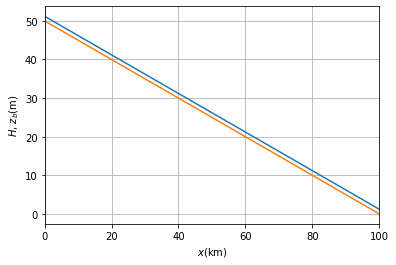

/var/folders/gn/5cn3kyv51x90tk3bzmr9yb0c0000gn/T/ipykernel_64878/511187010.py:184: RuntimeWarning: invalid value encountered in true_divide
  __tilde_Lambda[:, 1]) = self.__Lambda(__tilde_Q/__tilde_A,
/var/folders/gn/5cn3kyv51x90tk3bzmr9yb0c0000gn/T/ipykernel_64878/511187010.py:131: RuntimeWarning: invalid value encountered in true_divide
  mod1 = dLambda**2. / Delta + .25 * Delta
/var/folders/gn/5cn3kyv51x90tk3bzmr9yb0c0000gn/T/ipykernel_64878/511187010.py:131: RuntimeWarning: divide by zero encountered in true_divide
  mod1 = dLambda**2. / Delta + .25 * Delta


1200.0
2400.000000000001
3600.0000000000014
4800.000000000001
6000.0
7200.000000000002
8400.000000000004
9600.0
10799.999999999998
11999.999999999996
13199.999999999989
14399.999999999989
15599.999999999989
16799.999999999985
18000.0
19200.0
20400.00000000001
21600.000000000004
22800.000000000004
24000.00000000001
25200.000000000007
26400.000000000015
27600.00000000001
28800.000000000004
30000.000000000004
31199.999999999993
32399.99999999999
33600.0
34800.00000000001
35999.999999999985
37200.00000000001
38400.0
39599.999999999985
40799.999999999985
41999.99999999998
43199.99999999998
44399.99999999997
45599.999999999985
46800.0
47999.99999999998
49199.99999999995
50399.999999999985
51599.99999999998
52799.99999999996
53999.99999999995
55199.999999999905
56399.999999999905
57599.999999999905
58799.99999999992
59999.999999999935
61199.999999999935
62399.99999999991
63599.99999999991
64799.99999999992
65999.99999999996
67199.99999999999
68399.99999999999
69599.99999999994
70799.999999999

In [8]:
# 計算実行
if __name__ == "__main__":
    """main関数."""
    dw = DynamicWave()
    dw.calc()